In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Self driving car model analysis

The purpose of this analysis is try to explain the train and test proceses. Analysing data and augmentation this to improve accurary and later simulation over udacity simulator.

Without further ado, let's start with the step-by-step process:

**Step 1**: Let's import required classes & functions:

In [2]:
from lib.config import Config
from lib.dataset.dataset_loader import DatasetLoader

from lib.model.model_factory import ModelFactory
from lib.model.metrics import rmse

from lib.data_generator import SteeringWheelAngleDataGenerator
from lib.image_preprocessor import ImagePreprocessor
from lib.augmentation.sample_augmenter import SampleAugmenter, NullSampleAugmenter
from lib.augmentation.image_augmentation_utils import choose_image, random_image_flip, \
                                         random_image_translate, random_image_shadow, \
                                         random_image_brightness

from lib.callback.callback_factory import CheckpointFactory, PlotLossesFactory
from lib.callback.adam_learning_rate_tracker import AdamLearningRateTracker

from lib.image_utils import load_image, vertical_crop_image, resize_image, rgb_to_yuv
from lib.plot_utils import show_image, show_histogram, histogram, histograms, show_sample, show_values, show_augmented_sample
from lib.file_utils import last_created_file_from


from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

Using TensorFlow backend.


**Step 2**: First of all check that has a GPU available. This is required to decrease learning training times: 

In [3]:
print("Available GPU's: ", K.tensorflow_backend._get_available_gpus())

Available GPU's:  ['/job:localhost/replica:0/task:0/device:GPU:0']


**Step 3**: Load config file.

In [22]:
cfg = Config('./config.yml')

### Load Train data

The dataset was previously generater using de **Training Mode** of UDacity simulator. This mode generate:

1. **IMG** directory that contain images taked with all cameras(left, center, right)

2. **driving_log.csv** file that contain examples with next columns:

In [5]:
cfg['dataset']['columns']

['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

When:
* **Center**, **Left** and **Right**: Are images paths. That images was taked from three cameras mounted in front of a car in the simulator.
* **Steering**: The car steering whell angle.
* **Throttle**: Car aceletation.
* **Reverse**
* **Speed**: Car speed.

**Step 1**: Load dataset

In [6]:
loader = DatasetLoader(cfg)

dataset = loader.load(
    features=cfg['dataset']['features'],
    labels=cfg['dataset']['labels']
)

dataset(8036) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_2/driving_log.csv 
dataset(6017) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_3/driving_log.csv 
dataset(3666) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_4/driving_log.csv 
dataset(7102) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_5/driving_log.csv 
dataset(3678) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_6/driving_log.csv 
dataset(7673) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_7/driving_log.csv 
dataset(6220) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_8/driving_log.csv 
dataset(11717) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_9/driving_log.csv 
dataset(2395) l

Features
	- Speed: 22.14829
	- Reverse: 0.0
	- Images:


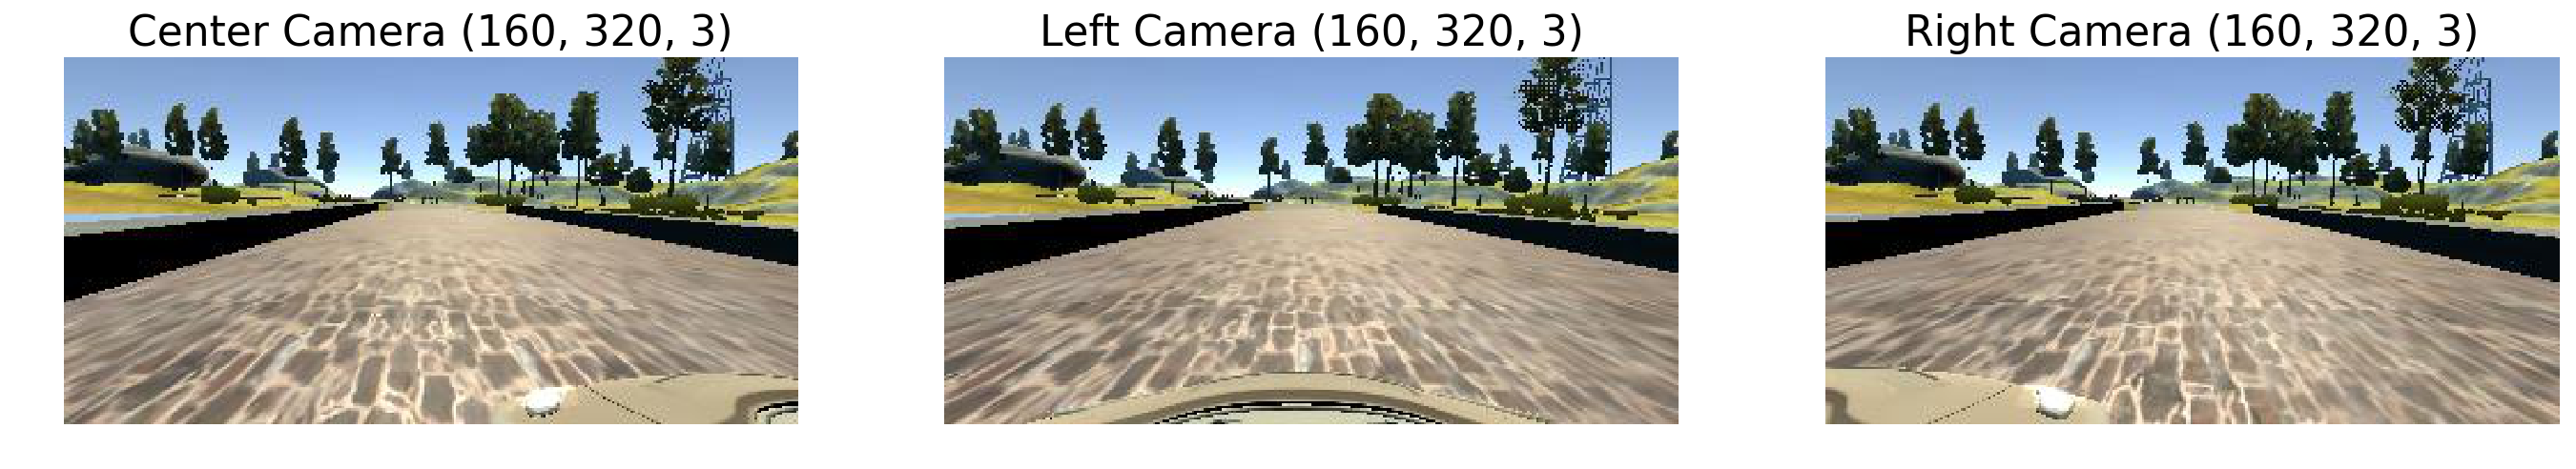

Labels
	- Steering: 0.0
	- Throttle: 0.0


In [7]:
show_sample(dataset[0])

**Step 2**: Show streering angle,speed, throttle histograms

/home/adrian/anaconda3/envs/self-driving-car-model/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


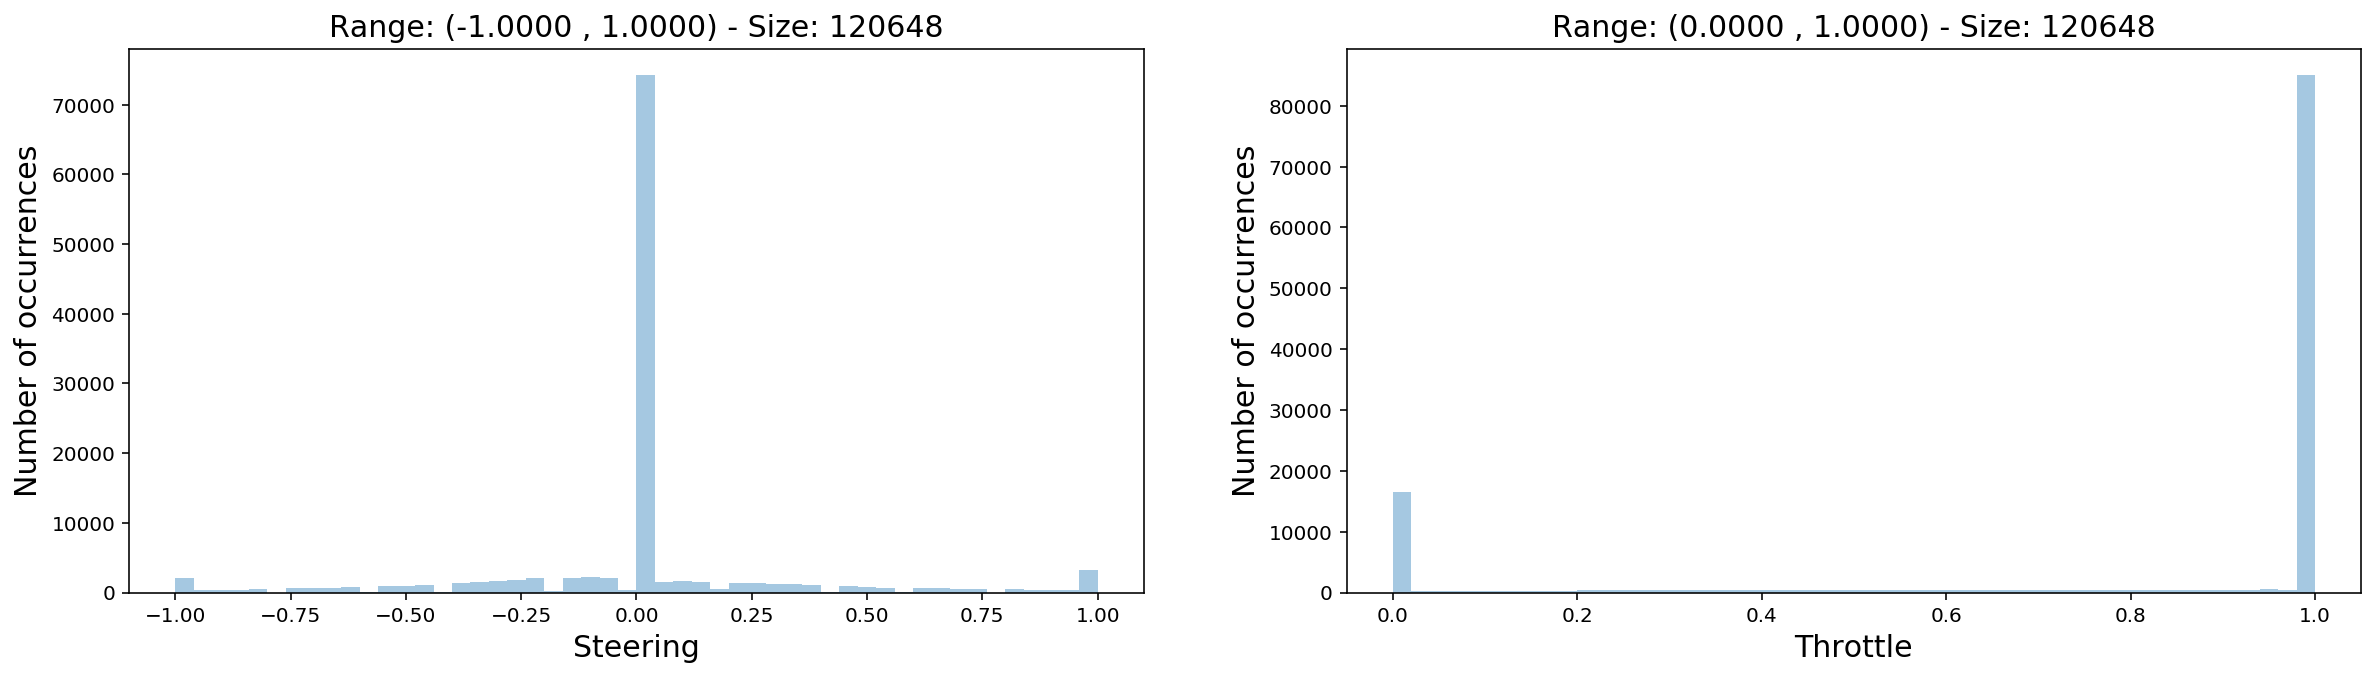

In [8]:
dataset.show_labels_stats()

**Step 2**: Split dataset in train and validation.

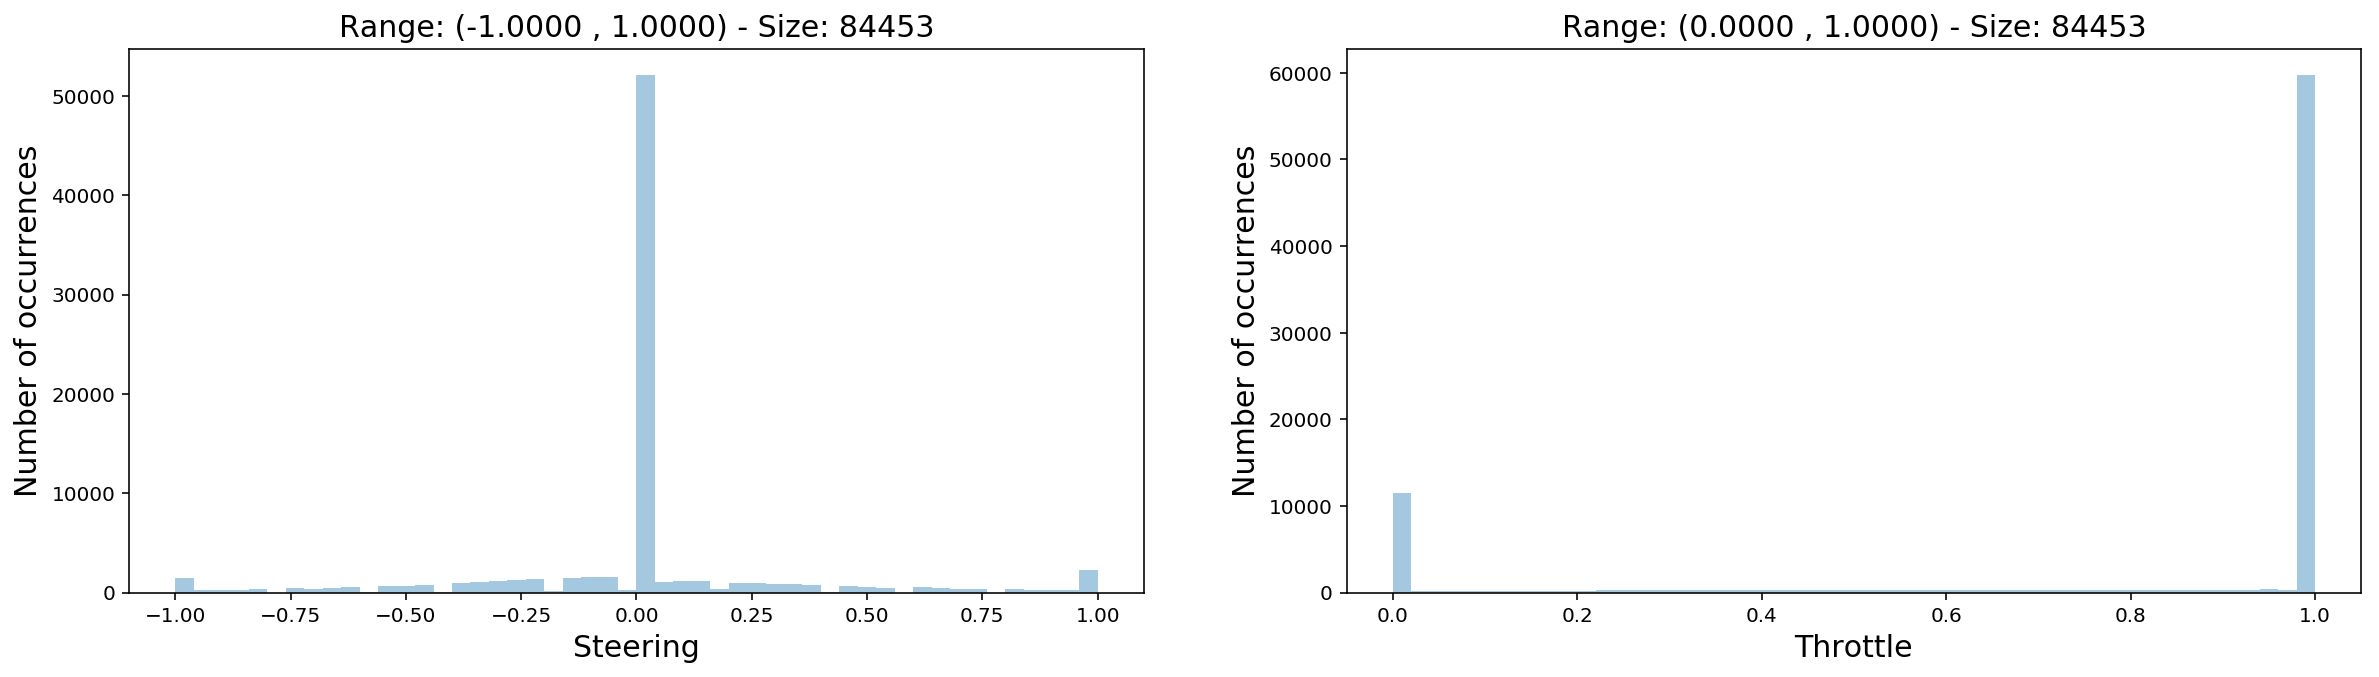

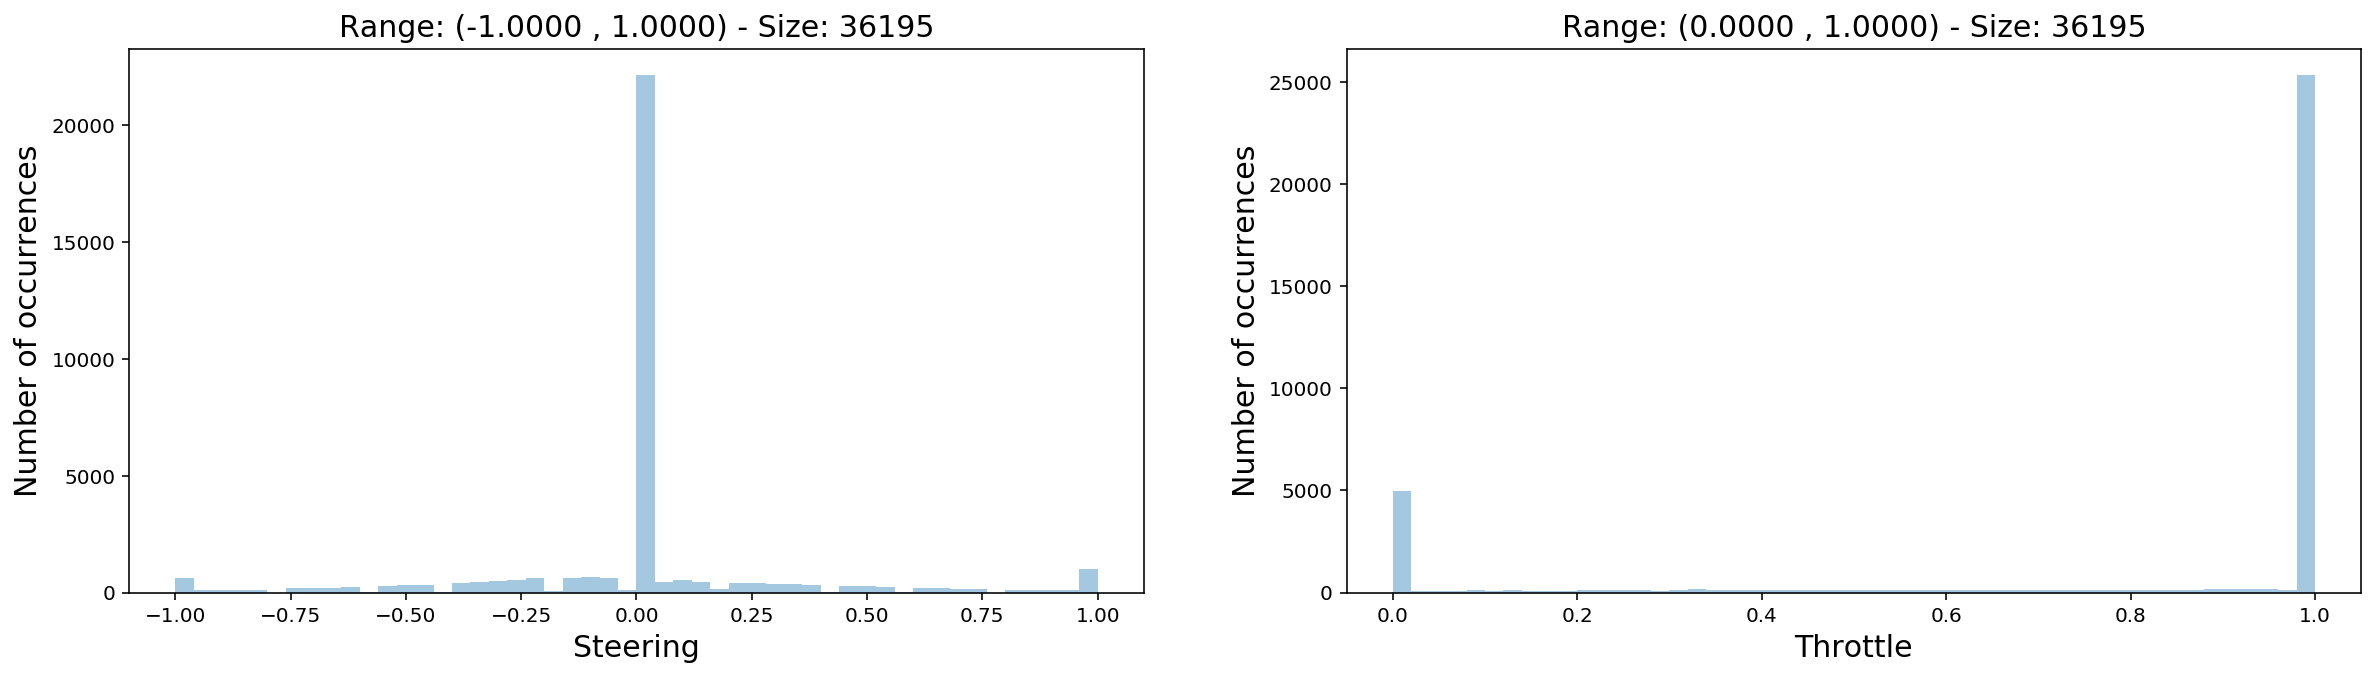

In [9]:
train_dataset, validation_dataset = dataset.split(percent=cfg['train']['validation_set_percent'], shuffle=True)
train_dataset.show_labels_stats()
validation_dataset.show_labels_stats()

### Data generation process

After all is necessary explain three importante points:

* A generator allow us to generator a dataset for augment and/or preprocess and in this way increase samples amount. 
* Since in most cases dataset does not fit in memory a generator allow as to save memory space, loading only a subset of this on each train batch.
* A generator also allow us to process data using multiples cpu cores.

On the other hand, data augmentation and preprocessing is required to improve model accuracy. Particularly for this problem is required two flows to generate samples:

* **Train samples generation**:
    * Augment & preprocess a randomly image from the center, left or right cameras.
    * Preproress agmented image.
    * Steering angles is adjustes in each case.

* **Validation samples generation**: Only preprocess center camera image.

But what does augmentation and preprocess means?
        
* **Augmentation steps**: 
    1. Randomly choose an image from the center, left or right, and adjust the steering angle.
    2. Randomly flip the image left <-> right, and adjust the steering angle.
    3. Randomly shift the image vertically and horizontally (translation).
    4. Generates and adds random shadow.
    5. Randomly adjust brightness of the image.

* **Preprocessing steps**:
    1. Crop the image (removing the sky at the top and the car front at the bottom).
    2. Resize the image to the input shape used by the network model.
    3. Convert the image from RGB to YUV (This is what the NVIDIA model does).

#### Augmentation steps

Let's get a samples centrar image to show each augmentation effect:

Features
	- Speed: 30.18647
	- Reverse: 0.0
	- Images:


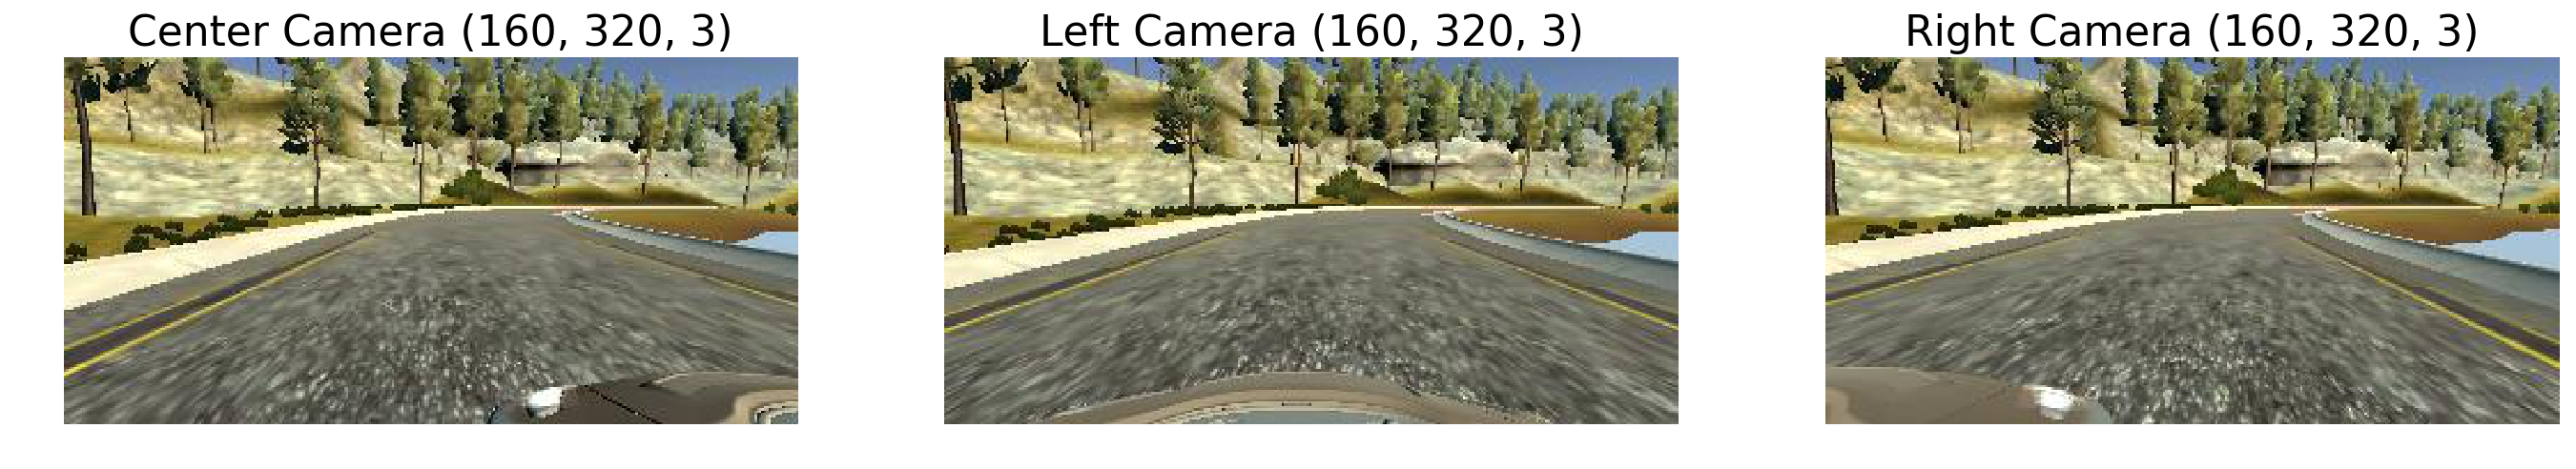

Labels
	- Steering: 0.100034
	- Throttle: 0.9855325999999999


In [10]:
sample = dataset.shuffle()[0]
show_sample(sample)

**Randomly choose an image**: From the center, left or right, and adjust
    the steering angle.

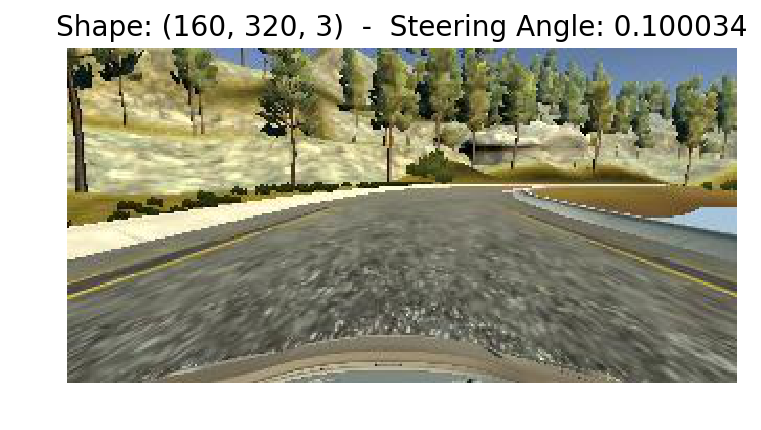

In [11]:
img, angle = choose_image(
    sample.feature('center'),
    sample.feature('left'),
    sample.feature('right'),
    sample.label('steering'),
    adjustment_angle=0.2
)
show_augmented_sample(img, angle)

**Randomly flip image**: Randomly flip the image left <-> right, and adjust the steering angle.

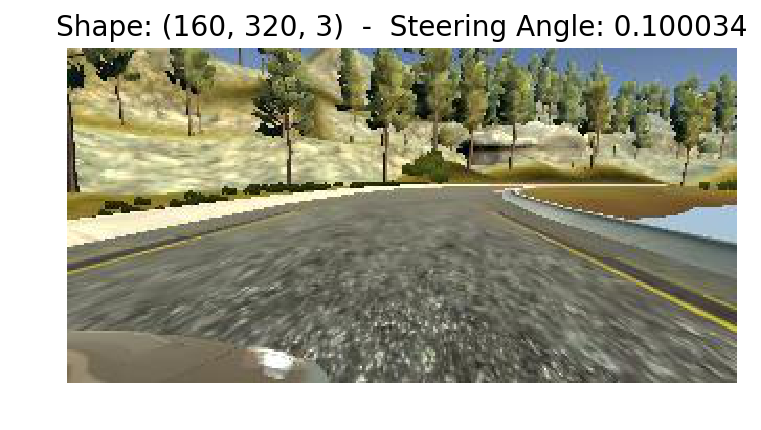

In [12]:
img, angle = random_image_flip(sample.feature_image('right'), sample.label('steering'))
show_augmented_sample(img, angle)

**Randomly translate**: Randomly shift the image vertically and horizontally.

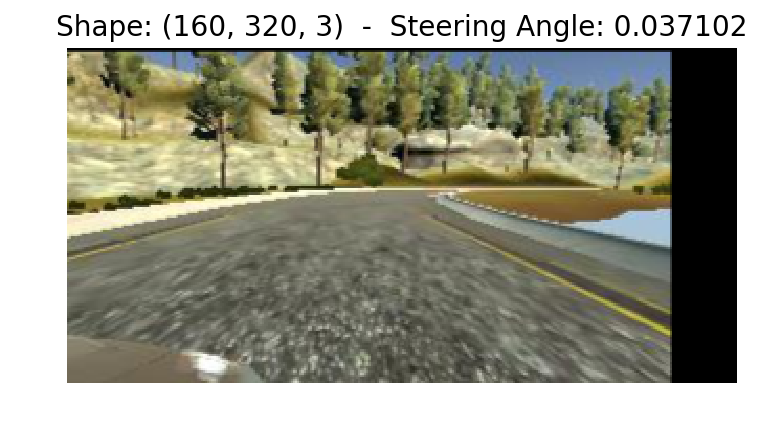

In [13]:
img, angle = random_image_translate(
    sample.feature_image('right'), 
    sample.label('steering'),
    range_x=100, 
    range_y=10,
    angle_delta=0.002
)
show_augmented_sample(img, angle)

**Random shadow**: Generates and adds random shadow.

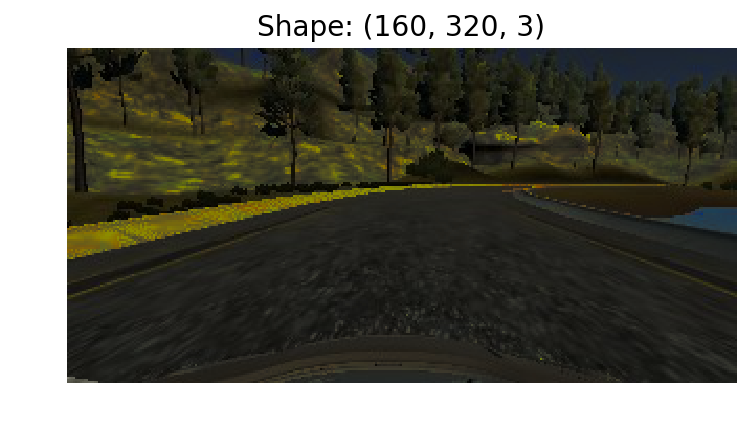

In [14]:
show_augmented_sample(random_image_shadow(sample.feature_image('center'), width=320, height=160))

**Randomly brightness**: Randomly adjust brightness of the image.

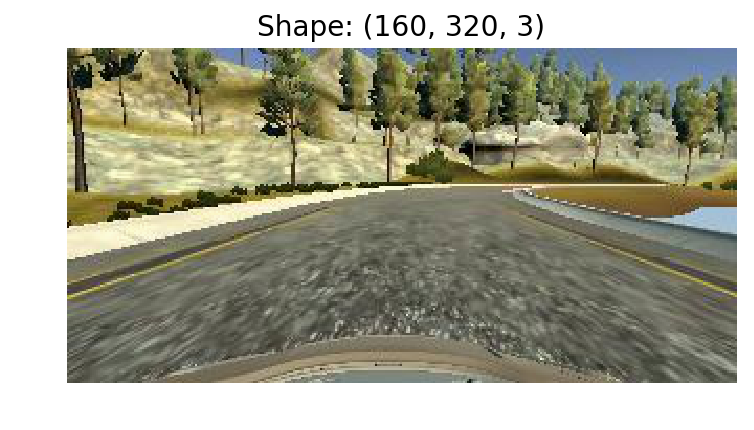

In [15]:
show_augmented_sample(random_image_brightness(sample.feature_image('center')))

#### Preprocessing steps

Let's get a samples centrar image to show each preprocessing step:

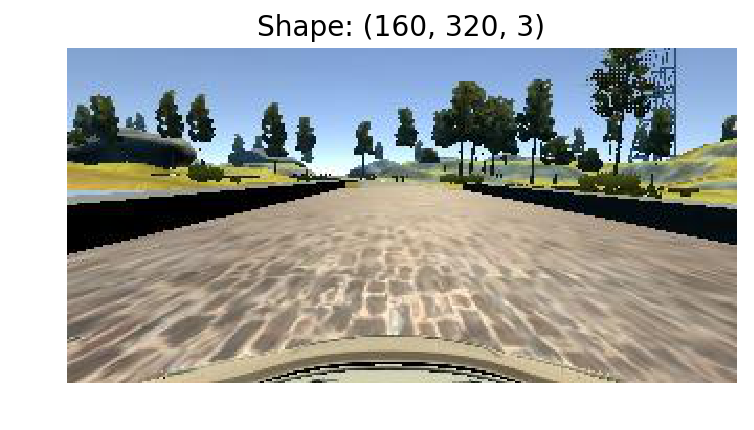

In [16]:
image = load_image(dataset[0].features[0])
show_augmented_sample(image)

**Step 1:** Randomly choose an image from the center, left or right, and adjust the steering angle.

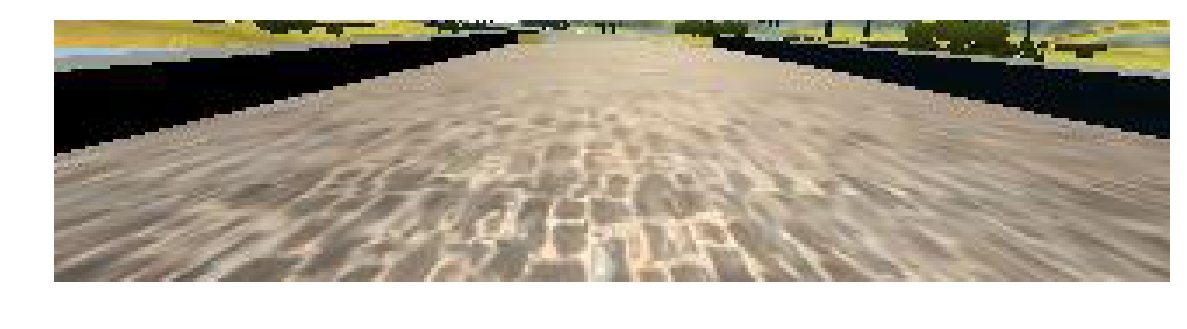

In [17]:
choped_image = vertical_crop_image(image, top_offset=60, bottom_offset=25)
show_image(choped_image)

**Step 2**: Resize the image to the input shape used by the network model.

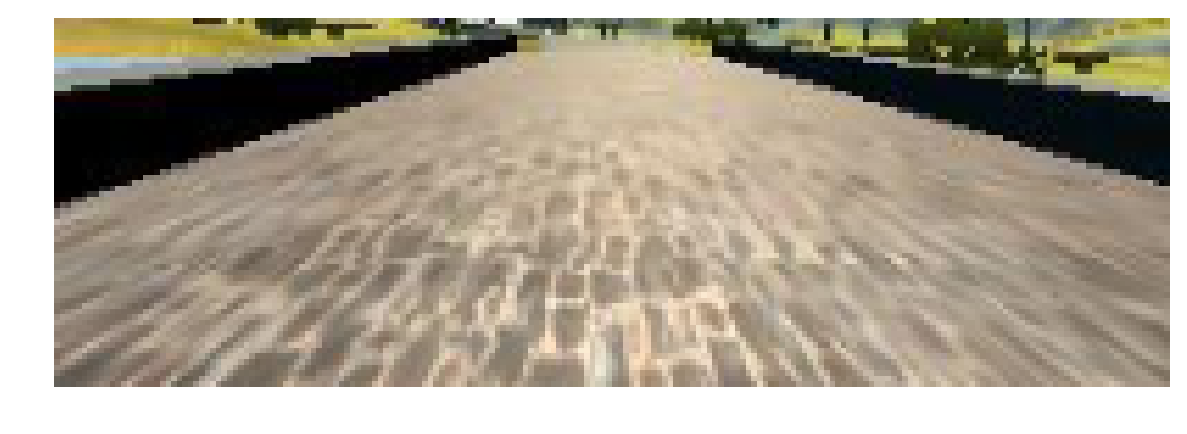

In [18]:
resized_image = resize_image(choped_image, 200, 66)
show_image(resized_image)

**Step 3**: Convert the image from RGB to YUV (This is what the NVIDIA model does).

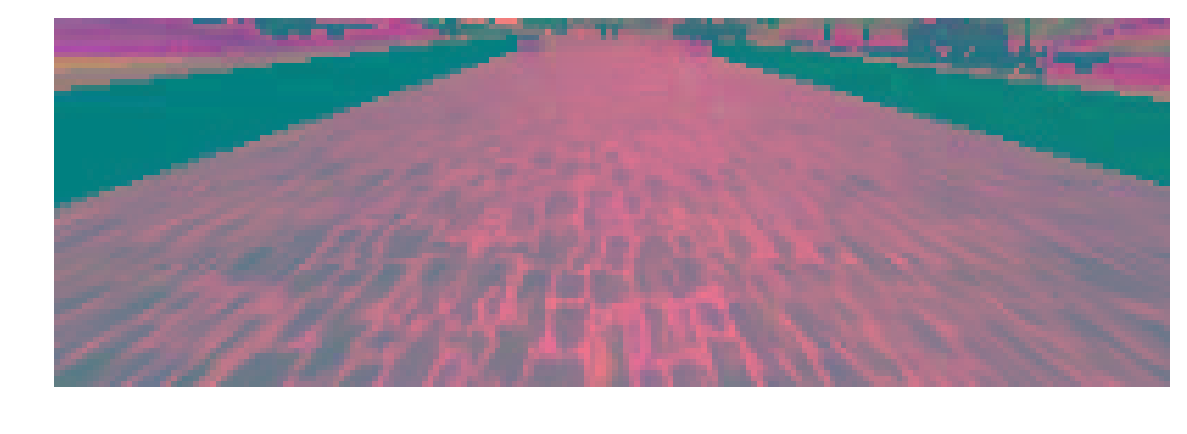

In [19]:
show_image(rgb_to_yuv(resized_image))

#### Create train and validation data generators

In [33]:
image_input_shape = (
    cfg['network']['image_input_shape']['height'],
    cfg['network']['image_input_shape']['width'],
    cfg['network']['image_input_shape']['channels']
)
variables_input_shape = (cfg['network']['variable_input_shape'],)

output_shape=[train_dataset.labels.shape[1]]
batch_size = cfg['train']['batch_size']
augment_threshold = cfg['train']['augment']['threshold']
choose_adjustment_angle =  cfg['train']['augment']['choose_adjustment_angle']
translate_range_x = cfg['train']['augment']['translate_range_x']
translate_range_y = cfg['train']['augment']['translate_range_y']
translate_angle_delta = cfg['train']['augment']['translate_angle_delta']
top_offset=cfg['train']['preprocess']['crop']['top_offset']
bottom_offset=cfg['train']['preprocess']['crop']['bottom_offset']
steer_threshold=cfg['train']['augment']['throttle']['steer_threshold']
speed_threshold=cfg['train']['augment']['throttle']['speed_threshold']
throttle_delta=cfg['train']['augment']['throttle']['throttle_delta']
choose_image_adjustment_angle=cfg['train']['augment']['choose_image_adjustment_angle']
image_translate_angle_delta=cfg['train']['augment']['image_translate_angle_delta']

In [34]:
print("Image shape: ", image_input_shape)
print("Variable shape: ", variables_input_shape)
print("Output shape: ", output_shape[0])

Image shape:  (66, 200, 3)
Variable shape:  (2,)
Output shape:  2


In [35]:
print("Number of samples by batch: ", batch_size)
print("Image augment threshold: ", augment_threshold)
print("Adjusment angle delta when choose an image: ", choose_adjustment_angle)
print("Image translate x range: ", translate_range_x)
print("Image translate y range: ", translate_range_y)
print("Image translate angles delta: ", translate_angle_delta)
print("Image crop top offset: ", top_offset)
print("Image crop bottom offset: ", bottom_offset)
print("Steer threshold: ", steer_threshold)
print("speed threshold ", speed_threshold)
print("Throttle delta: ", throttle_delta)
print("Choose image adjustment angle: ", choose_image_adjustment_angle)
print("Image translate angle delta: ", image_translate_angle_delta)

Number of samples by batch:  100
Image augment threshold:  0.6
Adjusment angle delta when choose an image:  0.25
Image translate x range:  100
Image translate y range:  10
Image translate angles delta:  0.0035
Image crop top offset:  55
Image crop bottom offset:  25
Steer threshold:  0.5
speed threshold  20
Throttle delta:  0.3
Choose image adjustment angle:  0.2
Image translate angle delta:  0.002


In [36]:
image_preprocessor = ImagePreprocessor(top_offset, bottom_offset, image_input_shape)

In [37]:
train_augmenter = SampleAugmenter(
    image_preprocessor,
    augment_threshold,
    translate_range_x, 
    translate_range_y,
    choose_image_adjustment_angle,
    image_translate_angle_delta,        
    steer_threshold,
    speed_threshold,
    throttle_delta
)

In [38]:
train_generator = SteeringWheelAngleDataGenerator(
    dataset=train_dataset,
    input_shapes=[image_input_shape, variables_input_shape],
    output_shape=output_shape,
    batch_size=batch_size,
    sample_augmenter=train_augmenter,
    shuffle_per_epoch=True
)

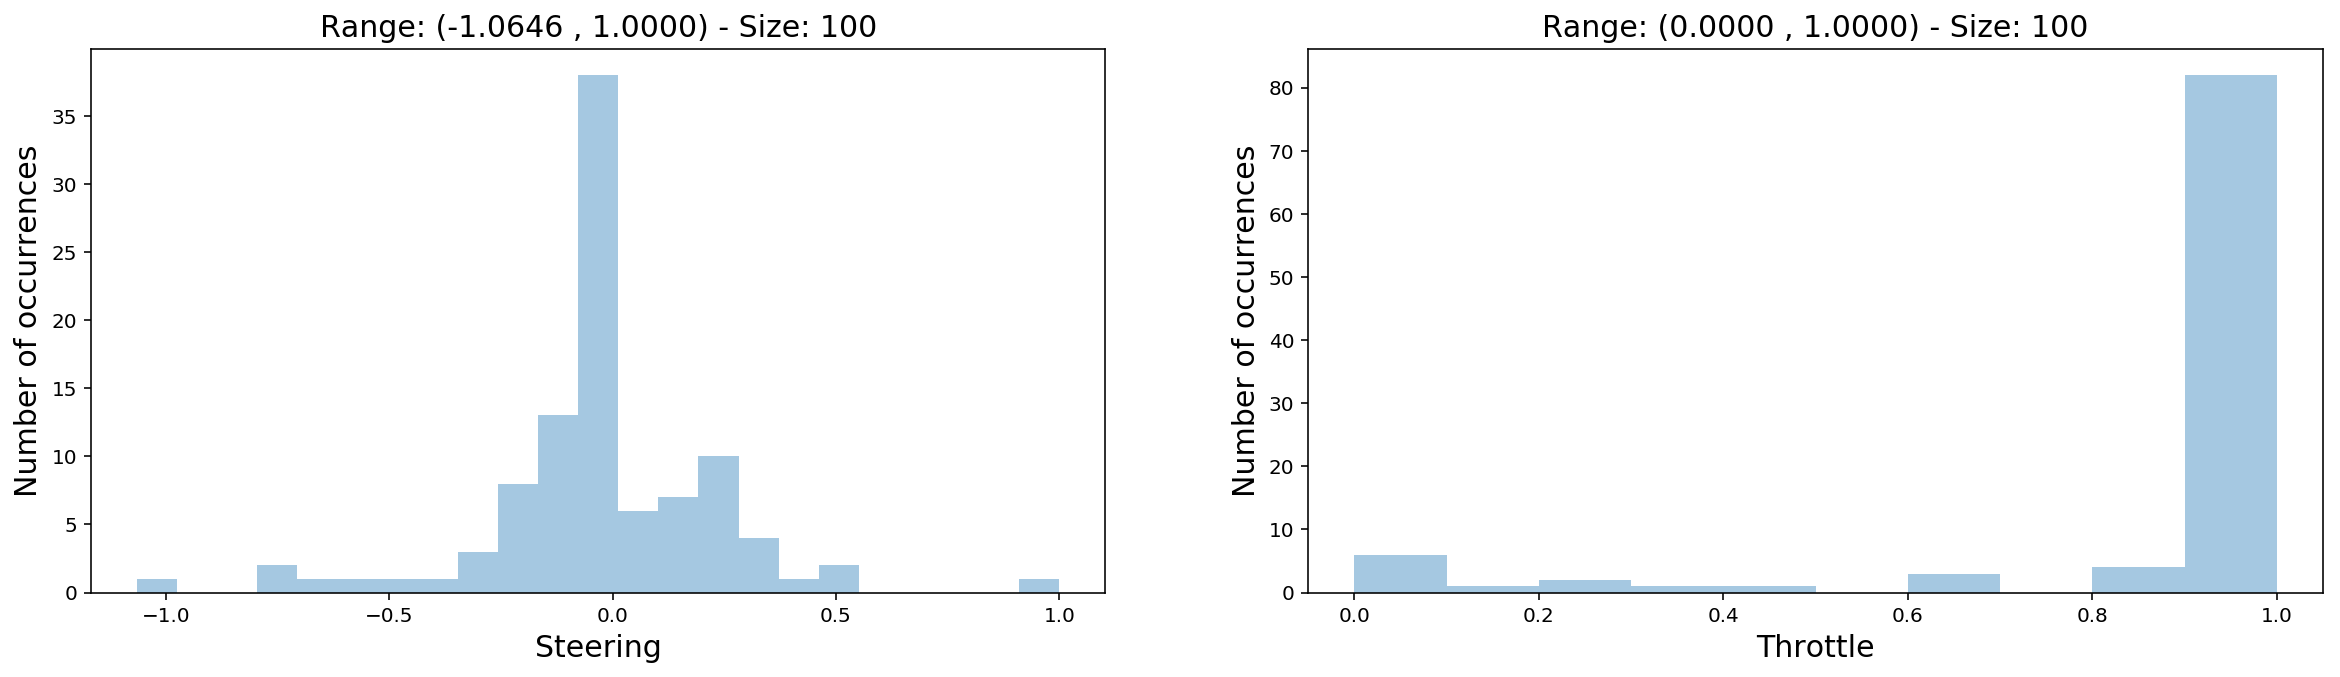

In [39]:
train_generator.any_batch().show_labels_stats()

In [40]:
validation_augmenter = NullSampleAugmenter(image_preprocessor)

In [41]:
validation_generator = SteeringWheelAngleDataGenerator(
    dataset=validation_dataset,
    input_shapes=[image_input_shape, variables_input_shape],
    output_shape=output_shape,
    sample_augmenter=validation_augmenter,
    batch_size=batch_size
)

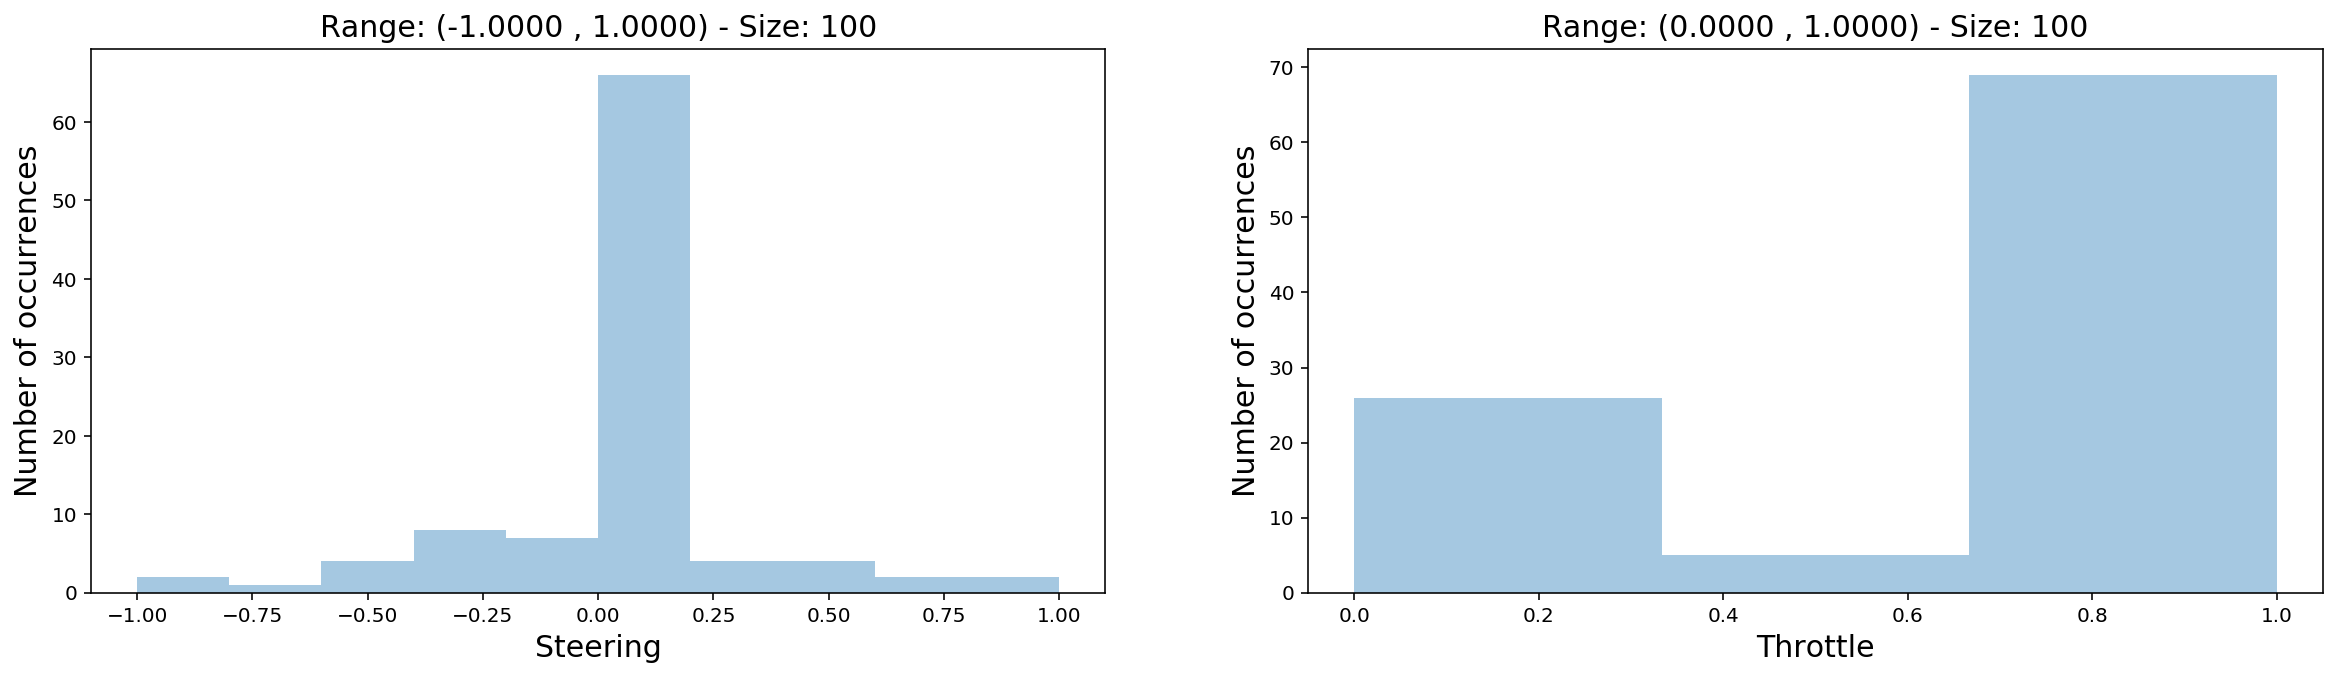

In [42]:
validation_generator.any_batch(excluded_labels=['reverse']).show_labels_stats()

### Create NVidia model

In [48]:
activation='relu'
loss='mean_squared_error'
optimizer=Adam(lr=0.00001)
metrics=[rmse]

model = ModelFactory.create_nvidia_model(activation, loss, metrics, optimizer)
# model.show()

In [49]:
last_weights_file_path = last_created_file_from("checkpoints/*.h5")
print(f'last_weights_file_path: {last_weights_file_path}')

last_weights_file_path: checkpoints/model_weights-epoch_001-steer_rmse_0.2140-throttle_rmse_0.2265.h5


In [50]:
# model.load_weights(last_weights_file_path)

### Train Model

In [51]:
steps_per_epoch=int(len(train_dataset)/batch_size)
epochs=15
steps_per_epoch, epochs

(844, 2)

**Steps per epoch**: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to the number of unique samples of your dataset divided by the batch size.

i.e.: When steps_per_epoch == 5 then model fit 5 baches por epoch and use 5 * batch_size samples.

**samples_per_epoch = steps_per_epoch * batch_size**


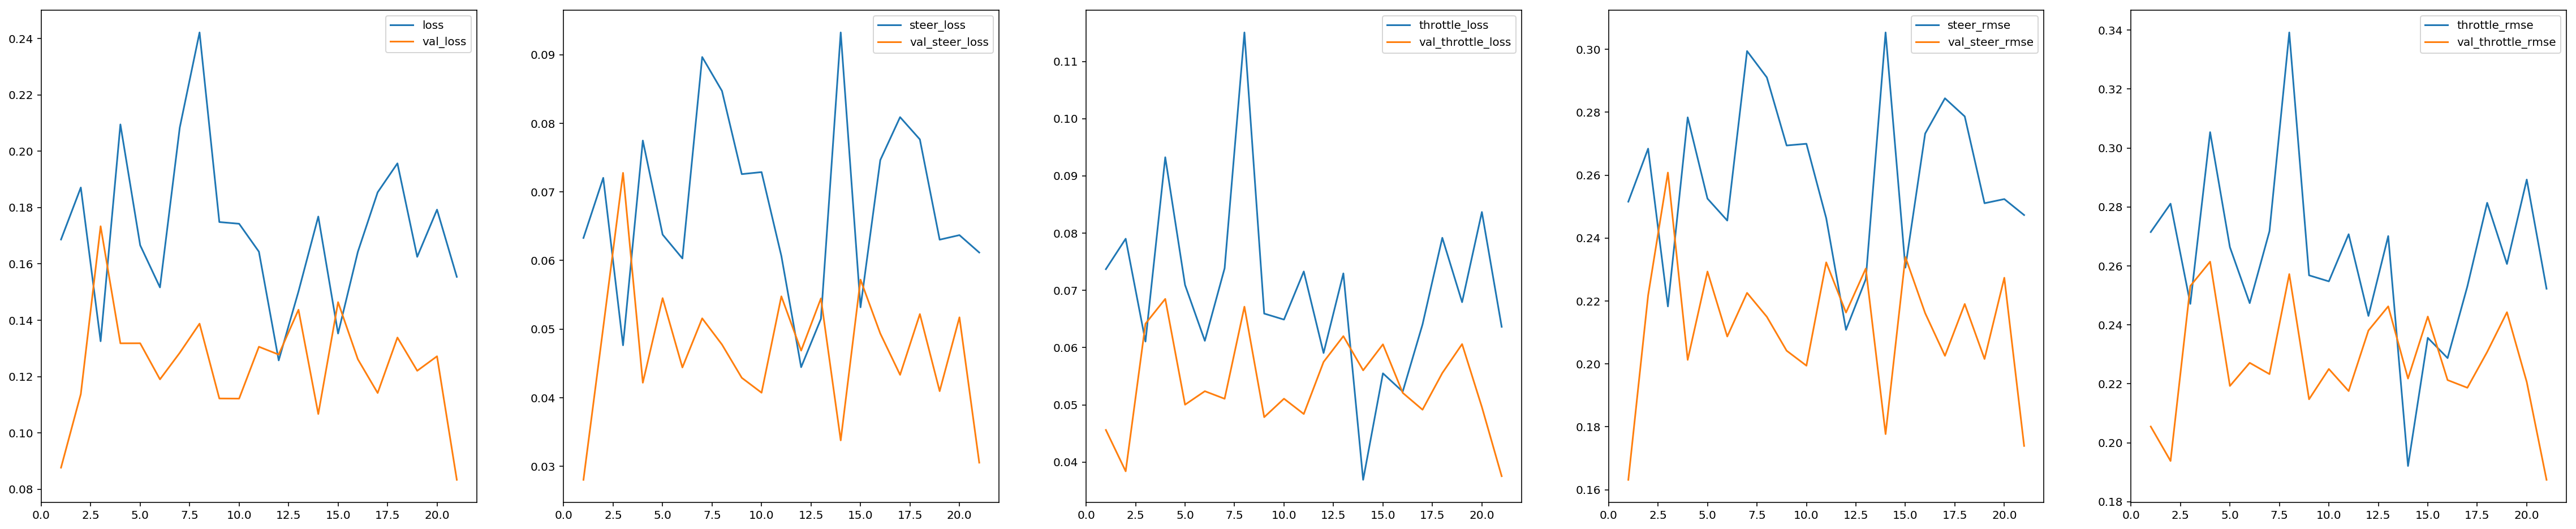

100/100 [==============================] - 0s 285us/step
Validation:
  - Loss (22): 0.096434 (⟰ 0.01308290)
  - Steer loss (22): 0.043034 (⟰ 0.01249978)
  - Throttle loss (22): 0.031883 (⟱ 0.00566677)
  - Steer rmse (22): 0.198008 (⟰ 0.02408284)
  - Throttle rmse (22): 0.171986 (⟱ 0.01545205)
Learning rate (22): 0.000009999999747 (=)
226/844 [=======>......................] - ETA: 1:07 - loss: 0.1640 - steer_loss: 0.0649 - throttle_loss: 0.0667 - steer_rmse: 0.2534 - throttle_rmse: 0.2568

Process ForkPoolWorker-98:
Process ForkPoolWorker-93:
Process ForkPoolWorker-91:
Process ForkPoolWorker-97:
Process ForkPoolWorker-102:
Process ForkPoolWorker-103:
Process ForkPoolWorker-89:
Process ForkPoolWorker-92:
Process ForkPoolWorker-94:
Process ForkPoolWorker-90:
Process ForkPoolWorker-95:
Traceback (most recent call last):
Process ForkPoolWorker-101:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/adrian/anaconda3/envs/self-driving-car-model/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/adrian/anaconda3/envs/self-driving-car-model/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/adrian/anaconda3/envs/self-driving-car-model/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args

KeyboardInterrupt: 

  File "/home/adrian/anaconda3/envs/self-driving-car-model/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/adrian/anaconda3/envs/self-driving-car-model/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/adrian/development/machine-learning/self-driving-car-model/lib/augmentation/sample_augmenter.py", line 87, in __augment_image_and_steering_angle
    image = random_image_shadow(image, image.shape[1], image.shape[0])
  File "/home/adrian/development/machine-learning/self-driving-car-model/lib/dataset/dataset_sample.py", line 31, in feature_image
    def feature_image(self, name): return load_image(self.feature(name))
  File "/home/adrian/anaconda3/envs/self-driving-car-model/lib/python3.6/site-packages/numpy/core/numeric.py", line 1866, in indices
    shape[:i] + (dim,) + shape[i+1:]
  File "/home/adrian/anaconda3/envs/self-driving-car-model/lib/python3.6/site-packages/kera

In [46]:
monitor_metric = 'val_steer_rmse'

checkpoint_factory = CheckpointFactory(path=cfg['train']['checkpoint_path'])

callbacks=[
    checkpoint_factory.create(metric=monitor_metric ), 
    EarlyStopping(monitor=monitor_metric , patience=2),
    PlotLossesFactory.create(validation_generator, plot_interval=50,  evaluate_interval=50), 
    ReduceLROnPlateau(monitor=monitor_metric, factor=0.3, patience=1, min_lr=0.000000000000001), 
    AdamLearningRateTracker(evaluate_interval=50)
]

model.train(
    generator=train_generator,
    validation_generator=validation_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=callbacks
) 

In [133]:
dataset = loader.load(
    features=cfg['dataset']['features'],
    labels=cfg['dataset']['labels'],
    mode='test'
)

dataset(814) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_0/driving_log.csv 
dataset(3538) loadded /home/adrian/development/machine-learning/self-driving-car-model/datasets/dataset_1/driving_log.csv 


In [139]:
test_generator = SteeringWheelAngleDataGenerator(
    dataset=validation_dataset,
    input_shapes=[image_input_shape, variables_input_shape],
    output_shape=output_shape,
    sample_augmenter=validation_augmenter,
    batch_size=len(dataset)
)
features, labels = test_generator[0]

In [142]:
model.load_weights(last_weights_file_path)

In [143]:
model.evaluate(features, labels, verbose=1)

4352/4352 [==============================] - 1s 247us/step

- loss: 0.09881956009742092
- steer_loss: 0.04716845130657449
- throttle_loss: 0.051651108297793305
- steer_rmse: 0.21323722929638975
- throttle_rmse: 0.22236347664147615



[0.09881956009742092,
 0.04716845130657449,
 0.051651108297793305,
 0.21323722929638975,
 0.22236347664147615]

In [144]:
import numpy as np

sample = dataset[0]
image = image_preprocessor.process(sample.feature_image('center'))

In [145]:
inputs = [
    np.array([image]), 
    np.array([sample.feature('speed')])
]
print(f'Inputs: ({inputs[0].shape}, {inputs[1].shape})')

results = model.predict(inputs)

for label, prediction in zip(['steering_angle', 'throttle'], results): print(f'{label.capitalize()}: {prediction[0][0]}')

Inputs: ((1, 66, 200, 3), (1,))
Steering_angle: -0.02936559170484543
Throttle: 1.01448392868042


### References

#### 1. Datasets

* [Udacity P3 - DriveGG](https://github.com/bpinaya/Udacity-P3-DriveGG)

#### 2. Links

* [Teaching Cars To Drive Using Deep Learning — Steering Angle Prediction](https://towardsdatascience.com/teaching-cars-to-drive-using-deep-learning-steering-angle-prediction-5773154608f2)
* [Teaching Vehicles To Drive Like We Do Using Deep Learning](https://github.com/kenshiro-o/CarND-Behavioral-Cloning-P3)